# Computer Simulations - Project 1. @ ELTE
# N-body problem of satellite formation and clustering of planetary debris inside an asteroid belt

In [1]:
from platform import python_version

print(python_version())

3.7.1


In [3]:
#%%bash

#jupyter nbextension install --py mayavi --user # Install if missing
#jupyter nbextension enable mayavi --user --py

In [30]:
%%cmd

rem jupyter nbextension install --py mayavi --user # Install if missing
jupyter nbextension enable mayavi --user --py

Microsoft Windows [Version 10.0.18362.356]
(c) 2019 Microsoft Corporation. Minden jog fenntartva.

C:\Users\masterdesky\Documents\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>
C:\Users\masterdesky\Documents\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>rem jupyter nbextension install --py mayavi --user # Install if missing

C:\Users\masterdesky\Documents\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>jupyter nbextension enable mayavi --user --py

C:\Users\masterdesky\Documents\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>

Enabling notebook extension mayavi/x3d/x3dom...
      - Validating: problems found:
        - require?  X mayavi/x3d/x3dom


In [31]:
import os
import random
import numpy as np

from mayavi import mlab
from tvtk.api import tvtk
mlab.init_notebook()

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift, DBSCAN, KMeans

from IPython.display import clear_output, display

Notebook initialized with ipy backend.


## Configure matplotlib and seaborn parameters

In [32]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

In [33]:
# [Mass in kg |
#  Distance from central celestail body in AU |
#  eccentricity |
#  Size in AU]
Planets={
    'Sun': [1.989e30, 0, 0.0001, 4.649e-03],
    'Moon': [7.348e22, 0.00257, 0.0549, 1.161e-05],
    'Mercury': [3.285e23, 0.466697, 0.205630, 1.631e-05],
    'Venus': [4.867e24, 0.728213, 0.006772, 4.045e-05],
    'Earth': [5.972e24, 1.017, 0.0167086, 4.259e-05],
    'Mars': [6.39e23, 1.666, 0.0934, 2.266e-05],
    'Jupiter': [1.898e27, 5.4588, 0.0489, 4.673e-04],
    'Saturn': [5.683e26, 10.1238, 0.0565, 3.893e-04],
    'Uranus': [8.681e25, 20.11, 0.046381, 1.695e-04],
    'Neptune': [1.024e26, 30.33, 0.009456, 1.646e-04],
    'Pluto': [1.309e22, 49.305, 0.2488, 7.954e-06],
    'Halley': [2.2e14, 35.082, 0.96714, 3.68e-08]
}

Planet_Colors={
    'Sun': np.array([216, 148, 29])/255,
    'Moon': np.array([204, 198, 195])/255,
    'Mercury': np.array([186, 186, 186])/255,
    'Venus': np.array([216, 194, 153])/255,
    'Earth': np.array([45, 52, 130])/255,
    'Mars': np.array([217, 120, 62])/255,
    'Jupiter': np.array([187, 155, 99])/255,
    'Saturn': np.array([222, 181, 82])/255,
    'Uranus': np.array([201, 239, 241])/255,
    'Neptune': np.array([72, 120, 242])/255,
    'Pluto': np.array([65, 25, 20])/255,
    'Halley': np.array([0,0,0])/255
}

In [68]:
AU_to_km = 149597871          # 1 AU = 149,597,871 km
GMPlusm = 4 * np.pi * np.pi   # Kepler's Third Law: G(M + m)/(4*pi^2) = 1 [AU^3/year^2]
G_AU = 1.9838e-29             # Gravitational constant [AU^3 * kg^-1 * year^-2]
G = 8.64960768e-13            # Gravitational constant [km^3 * kg^-1 * hour^-2]
c = 63197.8                   # Speed of light [AU/year]

## Transfer function

In [35]:
def transfer_function(t, cutoff):
    
    scale = 60
    r = np.zeros(len(t))
    norm = 1 / np.e**(-1/scale*np.abs(cutoff))
    for i, k in enumerate(t):
        if np.abs(k) < cutoff:
            r[i] = 1
        else:
            r[i] = norm * np.e**(-1/scale*np.abs(k))
    return r

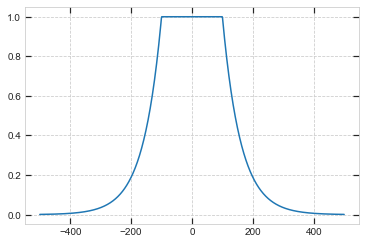

In [36]:
func = np.linspace(-500,500,999)

plt.plot(func, transfer_function(func, cutoff=100))

plt.show()

## Generating mass and size of small bodies

#### Sourced from
- Krasinsky, G.A. & Pitjev, N. & Vasilyev, Mikhail & Yagudina, Eleonora. (2002). Hidden Mass in the Asteroid Belt. Icarus. 158. 98-105. 10.1006/icar.2002.6837. doi:[10.1006/icar.2002.6837](https://doi.org/10.1006/icar.2002.6837)

For C, S and M types:
$$
\overline{\rho_{C}} = 1.38 \frac{\text{g}}{\text{cm}^{3}} = 1380 \frac{\text{kg}}{\text{m}^{3}}
$$

$$
\overline{\rho_{S}} = 2.27 \frac{\text{g}}{\text{cm}^{3}} = 2270 \frac{\text{kg}}{\text{m}^{3}}
$$

$$
\overline{\rho_{T}} = 5.32 \frac{\text{g}}{\text{cm}^{3}} = 5320 \frac{\text{kg}}{\text{m}^{3}}
$$

In [37]:
n_bodies = int(2e04)

In [14]:
# In kg/m^3
rho_C = 1380
rho_S = 2270
rho_T = 5320

In [15]:
# Radius in meters
lowest_R = 500
highest_R = 5000

geometries = np.zeros((n_bodies, 2))

for i in range(n_bodies):
    
    radius = np.random.randint(low=lowest_R, high=highest_R)
    volume = 4/3 * radius**3 * np.pi
    mass = volume * rho_S
    
    geometries[i,0] = mass
    geometries[i,1] = radius

## Generating coordinates of small bodies

In [16]:
def sign_choose():
    return -1 if random.random() < 0.5 else 1

In [70]:
coordinates = np.zeros((n_bodies, 3))
velocities = np.zeros((n_bodies, 3))

planet = 'Jupiter'
dr = 1.5
r = 3
R = Planets[planet][3] * AU_to_km
max_e = 0.4

# Focal distance of trajectories
# This is basically the central object's coordinates
obliquity = 0.2
c = obliquity * R

for i in range(n_bodies):
    # Semi-major and semi-minor axes
    # Generating perigeon distances and eccentricities
    # and calculating semi-major axis lengths using these
    # r_p = a * (1 - e^2) --> a = r_p / (1 - e^2)
    r_p = (R + 1) * r + R * np.random.rand() * dr
    e = np.random.random() * max_e
    a = r_p / (1 - e**2)
    # Calculating semi-minor axis length and eccentricity
    # c = sqrt(a^2 - b^2) |
    # e = c/a             | 
    # --> e = sqrt(1 - (b/a)^2)
    # --> b = +- sqrt(a^2 * (1 - e^2))
    b = np.sqrt(a**2 * (1 - e**2))

    if i < n_bodies//2:
        x_coord = np.random.randint(a) * sign_choose()
        y_coord = b/a * np.sqrt(a**2 - x_coord**2) * sign_choose()
    else:
        y_coord = np.random.randint(b) * sign_choose()
        x_coord = a * np.sqrt(1 - (y_coord/b)**2) * sign_choose()
    z_coord = np.random.randint(a) * 1/10 * sign_choose()
    
    # Norm back to AU
    x_coord /= AU_to_km
    y_coord /= AU_to_km
    z_coord /= AU_to_km

    # v = sqrt(GM * (2/r - 1/a))
    # [v] = sqrt(AU^3 * kg^-1 * year^-2 * kg * AU^-1) =
    #     = sqrt(AU^2 * year^-2) = AU/year
    v_x = np.sqrt(G_AU * Planets[planet][0] * (2/np.abs(x_coord) - 1/(a/AU_to_km)))
    v_y = np.sqrt(G_AU * Planets[planet][0] * (2/np.abs(y_coord) - 1/(a/AU_to_km)))
    v_z = np.sqrt(G_AU * Planets[planet][0] * (2/np.abs(z_coord) - 1/(a/AU_to_km)))
    
    # Save coordinates and velocities
    # [r] = km
    # v = [km/h]
    coordinates[i,0] = x_coord * AU_to_km
    coordinates[i,1] = y_coord * AU_to_km
    coordinates[i,2] = z_coord * AU_to_km
    velocities[i,0] = v_x * AU_to_km
    velocities[i,1] = v_y * AU_to_km
    velocities[i,2] = v_z * AU_to_km

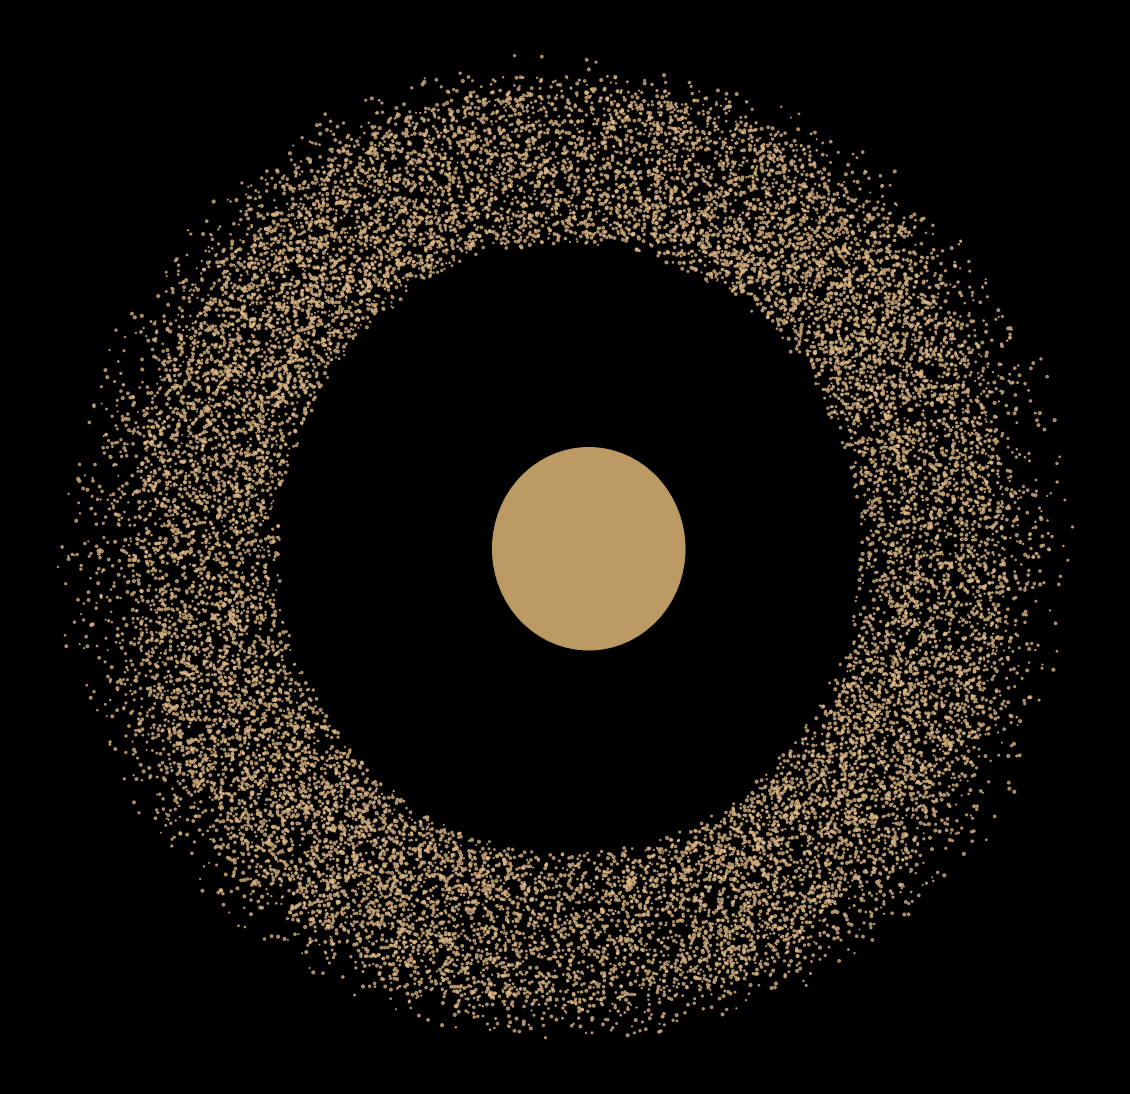

In [77]:
fig, axes = plt.subplots(figsize=(20, b/a*20), facecolor='black')
axes.set_facecolor('black')
axes.axis('off')

axes.scatter(coordinates[:,0], coordinates[:,1],
             color='burlywood', s=geometries[:,1]/lowest_R, alpha=0.7)

Planet_Pch = Circle(xy=(c,0), radius=R,
                    ec=Planet_Colors[planet], fc=Planet_Colors[planet])
axes.add_patch(Planet_Pch)

axes.set_xticks([])
axes.set_yticks([])

plt.show()

## 3D plot

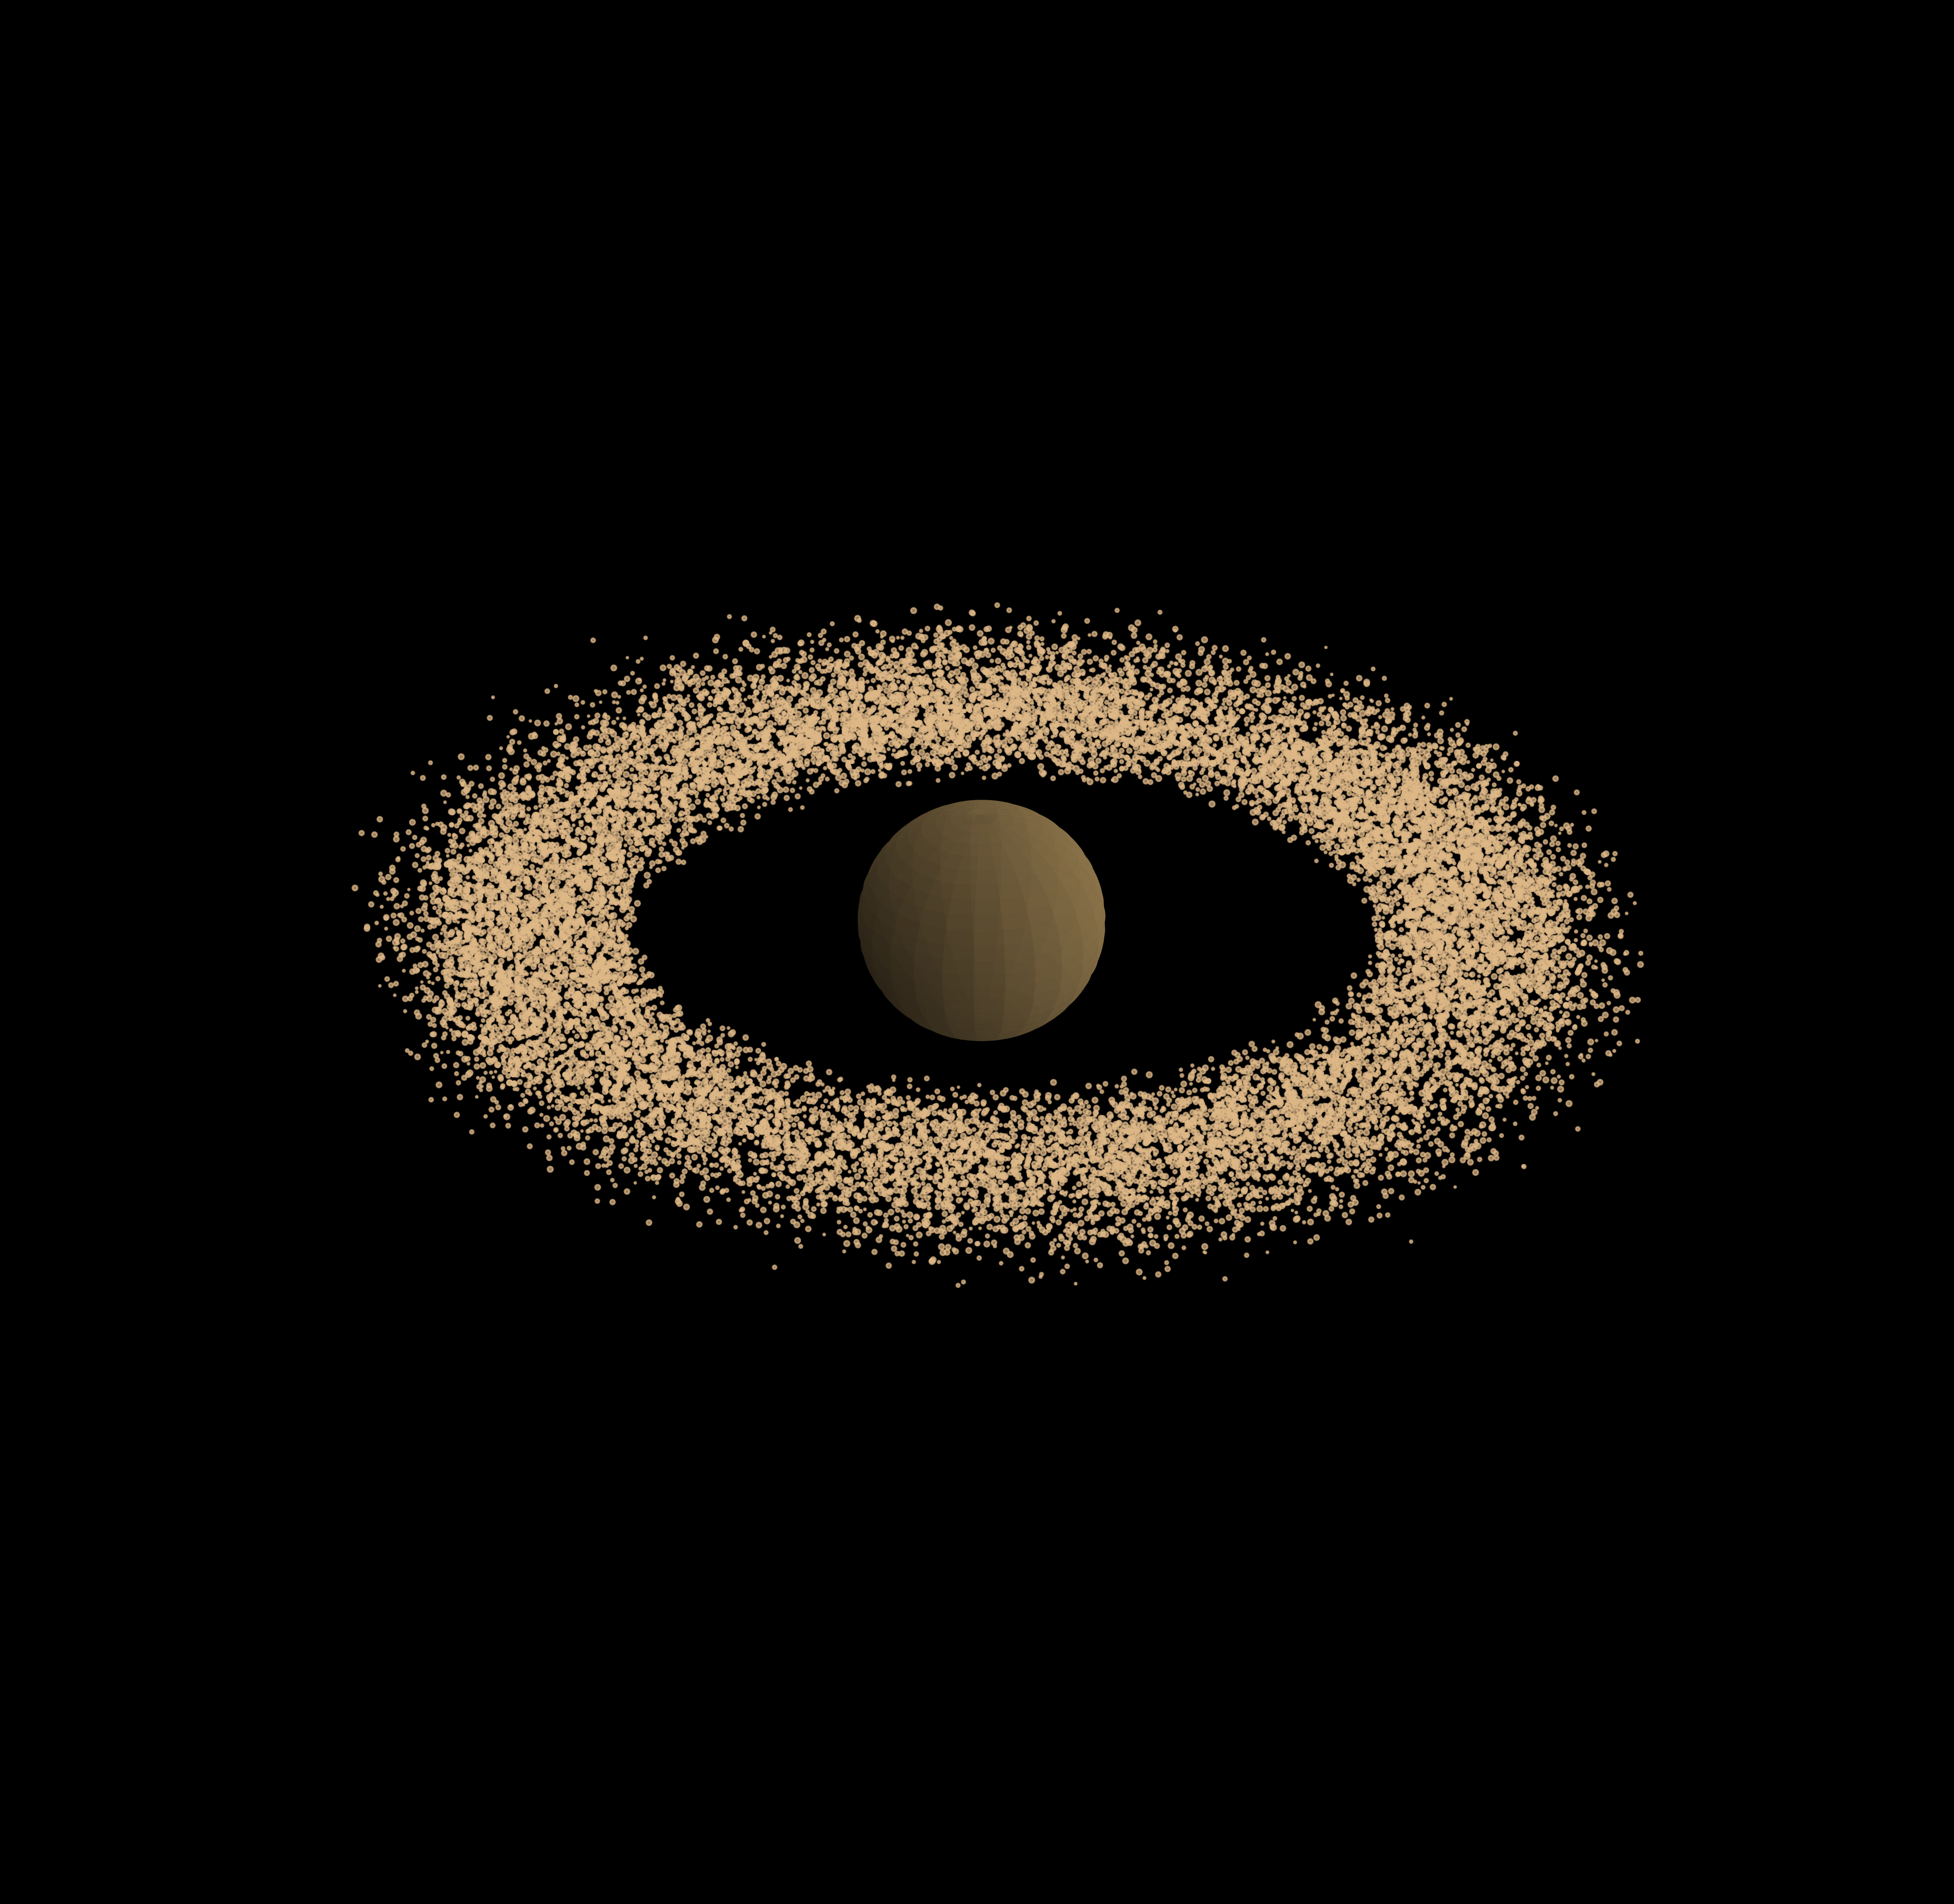

In [55]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300, facecolor='black', subplot_kw={'projection' : '3d'})
#ax.set_aspect('equal')

azimuth = 120
elevation = 30
ax.view_init(elevation, azimuth)
ax.set_facecolor('black')
ax.axis('off')

scale = 1.2
ax.set_xlim3d(-a*scale, a*scale)
ax.set_ylim3d(-a*scale, a*scale)
ax.set_zlim3d(-a*scale, a*scale)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Plot planet
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x+c, y, z, rstride=4, cstride=4, color=Planet_Colors[planet], linewidth=0, alpha=0.5)
ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2],
            edgecolor=None, color='burlywood', s=geometries[:,1]/lowest_R, alpha=0.7)

plt.show()

## Mayavi high-quality models

#### Sources:
- https://docs.enthought.com/mayavi/mayavi/auto/example_tvtk_in_mayavi.html
- https://stackoverflow.com/questions/53074908/map-an-image-onto-a-sphere-and-plot-3d-trajectories
- https://www.solarsystemscope.com/textures/

In [56]:
os.listdir('./img_src/')

['ceres_fictional.jpg',
 'earth.jpg',
 'earth_blue.png',
 'earth_clouds.jpg',
 'earth_daymap.jpg',
 'earth_nightmap.jpg',
 'eris_fictional.jpg',
 'haumea_fictional.jpg',
 'jupiter.jpg',
 'makemake_fictional.jpg',
 'mars.jpg',
 'mercury.jpg',
 'moon.jpg',
 'neptune.jpg',
 'saturn.jpg',
 'saturn_ring_alpha.png',
 'sun.jpg',
 'uranus.jpg',
 'venus_atmosphere.jpg',
 'venus_surface.jpg']

In [57]:
fig = mlab.figure(size=(800,b/a*800))

image_file = './img_src/{0}.jpg'.format(planet.lower())

# load and map the texture
img = tvtk.JPEGReader()
img.file_name = image_file
texture = tvtk.Texture(input_connection=img.output_port, interpolate=1)
# (interpolate for a less raster appearance when zoomed in)

# use a TexturedSphereSource, a.k.a. getting our hands dirty
Nrad = 180

# create the sphere source with a given radius and angular resolution
sphere = tvtk.TexturedSphereSource(radius=R, theta_resolution=Nrad,
                                   phi_resolution=Nrad)

# assemble rest of the pipeline, assign texture    
sphere_mapper = tvtk.PolyDataMapper(input_connection=sphere.output_port)
sphere_actor = tvtk.Actor(mapper=sphere_mapper, texture=texture)

asts = mlab.points3d(coordinates[:,0], coordinates[:,1], coordinates[:,2], geometries[:,1],
                     colormap="copper", scale_factor=0.5)

fig.scene.add_actor(sphere_actor)

display(fig)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03\x1d\x08\x02\x00\x00\x00\xec\xf6\x85…

## RK4

In [94]:
dt = 10e-3 * 24

In [95]:
coordinates

array([[  64768.        , -302419.53167021,    1640.4       ],
       [ -89196.        , -246475.1752893 ,   14533.8       ],
       [  51310.        ,  286757.80406942,   19458.6       ],
       ...,
       [-232883.95406212,   38657.        ,  -21990.2       ],
       [-301136.35529597,  -98074.        ,   31524.3       ],
       [ 247092.21526688, -136184.        ,    3241.9       ]])

In [96]:
velocities

array([[1.86777108e+09, 6.55462559e+08, 1.23809419e+10],
       [1.53165534e+09, 7.36420443e+08, 4.10686015e+09],
       [2.11870476e+09, 6.74182033e+08, 3.54003639e+09],
       ...,
       [7.40673845e+08, 2.44701583e+09, 3.30619706e+09],
       [6.64214792e+08, 1.47466494e+09, 2.75707773e+09],
       [7.57761107e+08, 1.18539426e+09, 8.79328333e+09]])

In [97]:
def sum_j(coord, r_cubed, axis):
    
    if axis=='x':
        ax = 0
    elif axis=='y':
        ax = 1
    elif axis=='z':
        ax = 2

    summ = 0
    for idx, j in enumerate(coordinates[:, ax]):
        summ += geometries[idx, 0] / r_cubed * (coord - j)
    
    return summ

In [98]:
def derivates(X, V):

    r_x = X[0]; r_y = X[1]; r_z = X[2]
    v_x = X[3]; v_y = X[4]; v_z = X[5]

    # Create placeholder array to store output of the RK4 step
    # f = [t, r_x, r_y, r_z, v_x, v_y, v_z]
    f = np.zeros(6)

    r_cubed = np.linalg.norm(X - coordinates[j,:])**3

    # a_i = -G * sum_j {m_j / |r_i - r_j|^3 * (r_i - r_j)}
    # d(t)/dt = 1
    t = 1
    # d(r_x)/dt = v_x
    f[0] = v_x
    # d(r_y)/dt = v_y
    f[1] = v_y
    # d(r_z)/dt = v_z
    f[2] = v_y
    # d(v_x) = a_x
    f[3] = - G * sum_j(r_x, r_cubed, axis='x')
    # d(v_y)/dt = a_y
    f[4] = - G * sum_j(r_y, r_cubed, axis='y')
    # d(v_z)/dt = a_z
    f[5] = - G * sum_j(r_z, r_cubed, axis='z')

    return f

In [100]:
def RK4_step(X, V, dt):
    k1 = dt * derivates(X, V)
    k2 = dt * derivates(X + 0.5 * k1, V + 0.5 * k1)
    k3 = dt * derivates(X + 0.5 * k2, V + 0.5 * k2)
    k4 = dt * derivates(X + k3, V + k3)

    dX = (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

    return dX